In [1]:
# Load the saved model
#from tensorflow.keras.models import load_model
#model = load_model('my_colorization_model.keras')

Autoencoder Method

In [2]:
# Install necessary packages
!pip install tensorflow-datasets

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Activation
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

c:\Users\Priyansu\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 100%|██████████| 2/2 [01:26<00:00, 43.21s/ url]


Dataset rock_paper_scissors downloaded and prepared to C:\Users\Priyansu\tensorflow_datasets\rock_paper_scissors\3.0.0. Subsequent calls will reuse this data.
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 330ms/step - loss: 0.2183 - val_loss: 0.0147
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 304ms/step - loss: 0.0090 - val_loss: 0.0067
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 305ms/step - loss: 0.0048 - val_loss: 0.0070
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 321ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 322ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 379ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 339ms/step - loss: 0.0022 - val_loss: 0.0043
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 329ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 372ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 315ms/step - lo

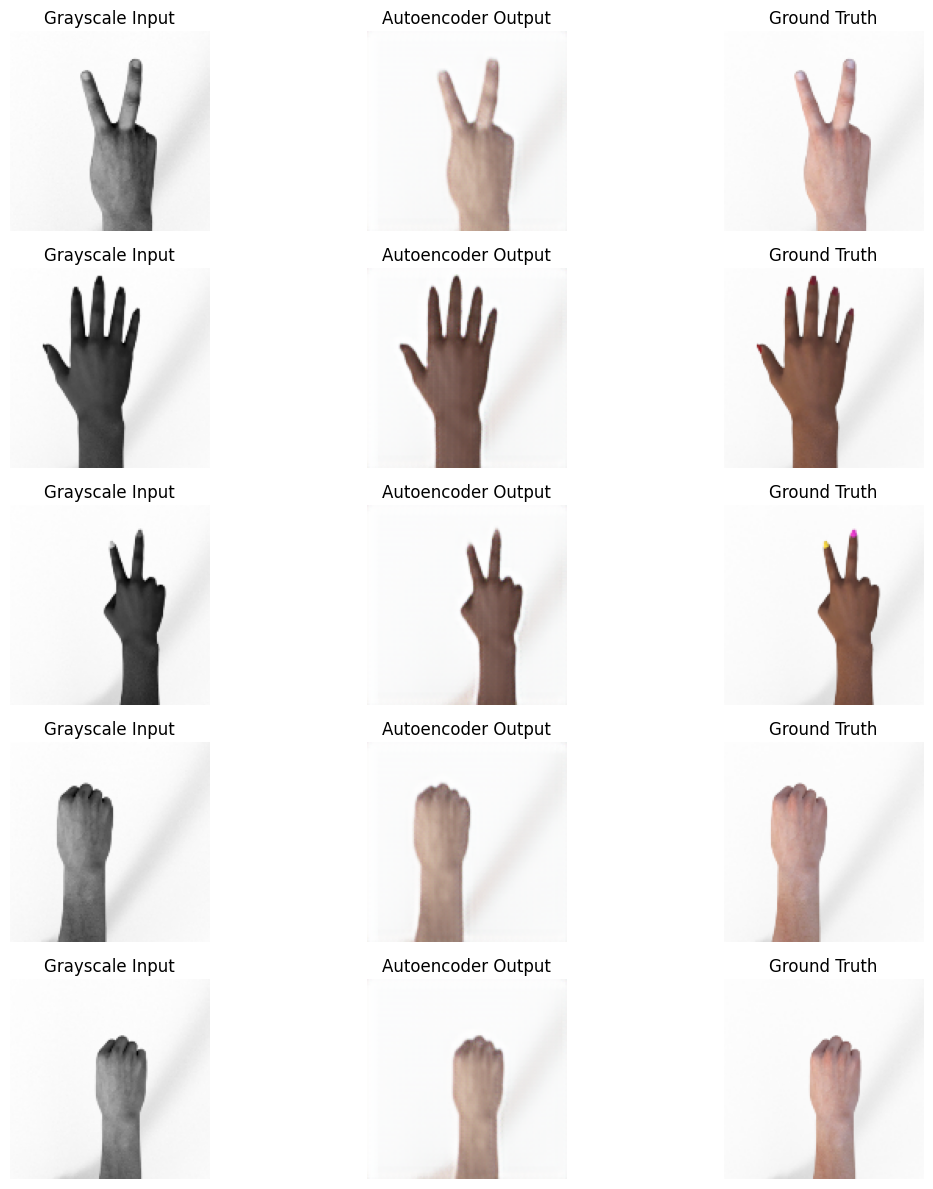

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds

# Load dataset (color images as both input and output)
ds_train, ds_test = tfds.load('rock_paper_scissors', split=['train', 'test'], as_supervised=True)

def preprocess(image, label):
    image = tf.image.resize(image, (128, 128)) / 127.5 - 1  # Normalize to [-1, 1]
    grayscale_image = tf.image.rgb_to_grayscale(image)  # Grayscale as input
    return grayscale_image, image  # Grayscale input, color output

ds_train = ds_train.map(preprocess).batch(32)
ds_test = ds_test.map(preprocess).batch(32)

# Build autoencoder model for colorization
def build_autoencoder():
    inputs = Input(shape=(128, 128, 1))
    # Encoding (downsampling)
    x = Conv2D(64, (3, 3), padding='same', strides=2, activation='relu')(inputs)
    x = Conv2D(128, (3, 3), padding='same', strides=2, activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    # Decoding (upsampling)
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    outputs = Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='tanh')(x)
    return Model(inputs, outputs)

# Compile and train the model
autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(ds_train, epochs=10, validation_data=ds_test)

# Evaluate and visualize results
for gray_images, color_images in ds_test.take(1):
    predicted_images = autoencoder.predict(gray_images)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 12))
    for i in range(5):  # Display first 5 images
        plt.subplot(5, 3, 3 * i + 1)
        plt.imshow(tf.squeeze(gray_images[i]), cmap='gray')
        plt.title("Grayscale Input")
        plt.axis('off')

        plt.subplot(5, 3, 3 * i + 2)
        plt.imshow(((predicted_images[i] + 1) * 127.5).astype(np.uint8))  # Rescale [-1, 1] to [0, 255]
        plt.title("Autoencoder Output")
        plt.axis('off')

        plt.subplot(5, 3, 3 * i + 3)
        plt.imshow(((color_images[i] + 1) * 127.5).numpy().astype(np.uint8))
        plt.title("Ground Truth")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [4]:
import tensorflow as tf


def calculate_psnr(ground_truth, predicted):
        mse = np.mean((ground_truth - predicted)**2)
        if mse == 0:
            return 100  # Avoid division by zero
        max_pixel = 255.0
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
        return psnr

In [5]:
 def calculate_ssim(ground_truth, predicted):
        ssim = tf.image.ssim(ground_truth, predicted, max_val=255.0)
        return ssim.numpy()

In [6]:
total_psnr = 0
total_ssim = 0
num_images = 0

for gray_images, color_images in ds_test:
    # The variable name should be 'autoencoder' instead of 'model'
    predicted_images = autoencoder.predict(gray_images)
    for i in range(predicted_images.shape[0]):
        # Assuming images are in the range [-1, 1]
        ground_truth = ((color_images[i] + 1) * 127.5).numpy().astype(np.uint8)
        predicted = ((predicted_images[i] + 1) * 127.5).astype(np.uint8)

        psnr = calculate_psnr(ground_truth, predicted)
        ssim = calculate_ssim(ground_truth, predicted)

        total_psnr += psnr
        total_ssim += ssim
        num_images += 1

average_psnr = total_psnr / num_images
average_ssim = total_ssim / num_images

print(f"Average PSNR: {average_psnr}")
print(f"Average SSIM: {average_ssim}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Average PSNR: 35.755678786659914
Average SSIM: 0.9629553556442261


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 376ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 384ms/step - loss: 0.0015 - val_loss: 0.0038
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 311ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 307ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 344ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 325ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 326ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 336ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 310ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 315ms/step - loss: 0.0012 - val_loss: 0.0035


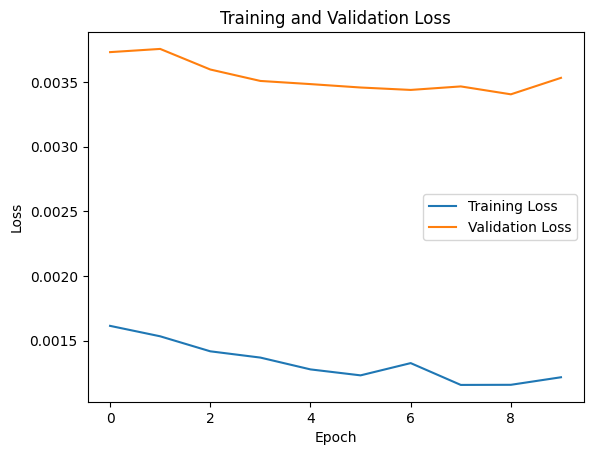

In [7]:
import matplotlib.pyplot as plt

# ... (your existing code) ...

# Train the model and store history
history = autoencoder.fit(ds_train, epochs=10, validation_data=ds_test)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()